In [ ]:
# Dataset taken from: https://archive.ics.uci.edu/dataset/162/forest+fires
# Author: P. Cortez
# Acessed: 11/12/2024
# License: Open Source
# Change log:
#   - dropped month and day
#   - Moved entire dataset to numpy array
#   - Made Target values binary
"""MLP Model built for prepicting a forest fire on given day- skewed towards positive prediction for ethics"""

'MLP Model built for prepicting a forest fire on given day- skewed for ethics'

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

In [95]:
from ucimlrepo import fetch_ucirepo 
forest_fires = fetch_ucirepo(id=162) 
   
X = forest_fires.data.features 
y = forest_fires.data.targets

X.drop(['month'], axis=1, inplace=True)
X.drop(['day'], axis=1, inplace=True)
dropped_index = range(0, 137, 1)
X = X.drop(dropped_index).reset_index(drop=True)
y = y.drop(dropped_index).reset_index(drop=True)

y = y.to_numpy()
X = X.to_numpy()

y_classifier = np.where(y > 0.0, 1, 0)
count_0 = 0
count_1 = 0
for i in y:
    if i == 0:
        count_0 += 1
    else:
        count_1 += 1
print("Count 0: ", count_0)
print("Count 1: ", count_1)
y_classifier = y_classifier.flatten()
print(X.shape)
print(y_classifier.shape)

Count 0:  110
Count 1:  270
(380, 10)
(380,)


C:\Users\willm\AppData\Local\Temp\ipykernel_29828\2815497592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['month'], axis=1, inplace=True)
C:\Users\willm\AppData\Local\Temp\ipykernel_29828\2815497592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['day'], axis=1, inplace=True)


In [96]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 1 accuracy: 0.6947368421052632
Fold 1 F1-score: 0.5877182304513566
Fold 1 Recall: 0.6947368421052632
Fold 1 Precision: 0.6382003395585739


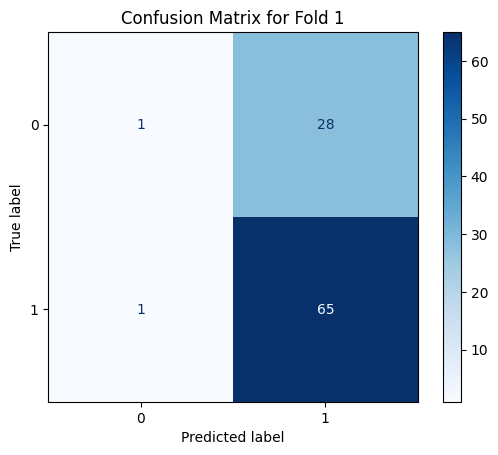

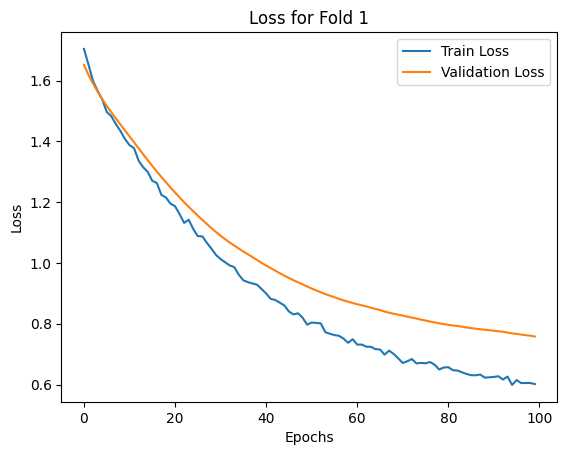

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 2 accuracy: 0.7157894736842105
Fold 2 F1-score: 0.6579709261573157
Fold 2 Recall: 0.7157894736842105
Fold 2 Precision: 0.6491984271022384


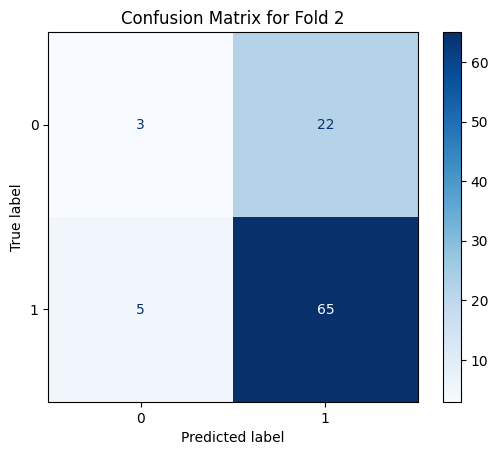

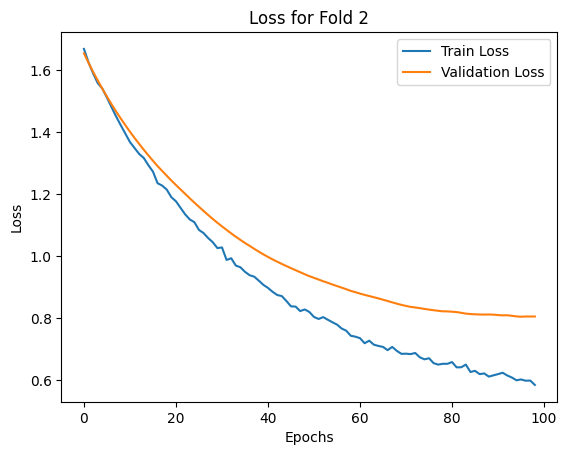

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 3 accuracy: 0.7684210526315789
Fold 3 F1-score: 0.7273739905318852
Fold 3 Recall: 0.7684210526315789
Fold 3 Precision: 0.7141560798548093


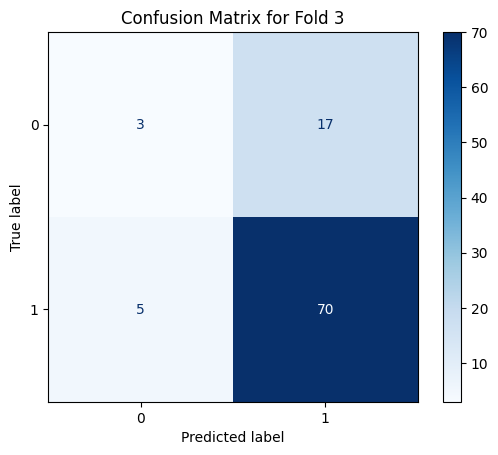

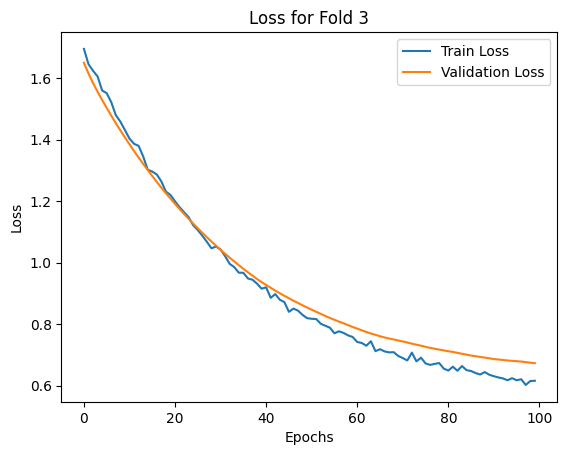

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 4 accuracy: 0.6842105263157895
Fold 4 F1-score: 0.6234744469870327
Fold 4 Recall: 0.6842105263157895
Fold 4 Precision: 0.7196284829721362


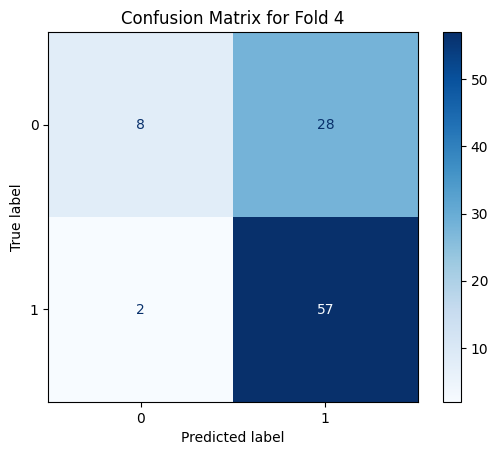

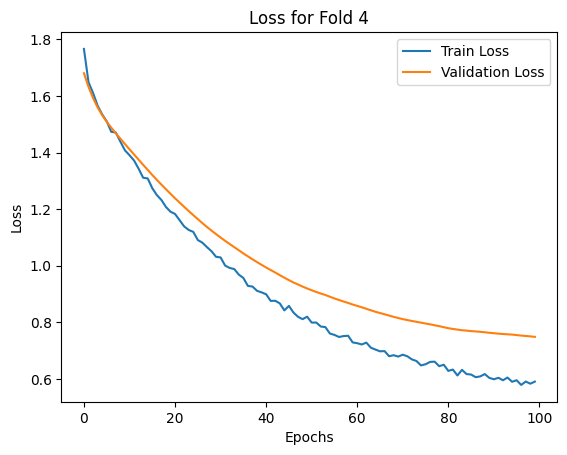

Mean accuracy across folds: 0.7158
Mean F-1 across folds: 0.6491
Mean Recall across folds: 0.7158
Mean Precision across folds: 0.6803


In [97]:
# Lists to store metrics
accuracy_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
conf_matrices = []
conf_matrices = []
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    # define input data for the fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_classifier[train_index], y_classifier[test_index]

    # Split training data for validation
    X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

    # Standardize the features
    scaler = StandardScaler()
    X_train_small_scaled = scaler.fit_transform(X_train_small)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=0.95)  # Retain 95% variance
    X_train_pca = pca.fit_transform(X_train_small_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Build a simple neural network model
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),  # Dropout with a 30% rate
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    #define callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and capture the history
    history = model.fit(X_train_pca, y_train_small, validation_data=(X_val_pca, y_val), epochs=100, batch_size=128, callbacks=[early_stop], verbose=0)

    # Evaluate the model on the test fold
    y_pred = (model.predict(X_test_pca) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    # print scores
    print(f"Fold {fold} accuracy: {accuracy}")
    print(f"Fold {fold} F1-score: {f1}")
    print(f"Fold {fold} Recall: {recall}")
    print(f"Fold {fold} Precision: {precision}")

    # append scores for mean
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.show()

    # Plot Training and Validation Loss for this fold
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss for Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    fold += 1

# Print overall accuracy
print(f"Mean accuracy across folds: {np.mean(accuracy_scores):.4f}")
print(f"Mean F-1 across folds: {np.mean(f1_scores):.4f}")
print(f"Mean Recall across folds: {np.mean(recall_scores):.4f}")
print(f"Mean Precision across folds: {np.mean(precision_scores):.4f}")